In [124]:
import IsoSpecPy
import ms_peak_picker
import brainpy
import numpy as np

%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [3]:
formula = "C24H26N6O5S1"
comp = brainpy.parse_formula(formula)

x = IsoSpecPy.IsoLayered(0.9999, formula)

In [4]:
x.sort_by_mass()

In [5]:
peaks = ms_peak_picker.PeakSet(
    [ms_peak_picker.FittedPeak(mass + brainpy.PROTON, prob * 100, prob, 0, 0, 0.01, prob, ) for mass, prob in zip(x.masses, x.probs)]
)
peaks.reindex()

In [6]:
def reprofile_fwhm(peaks, fwhm, **kwargs):
    # Create a continuum spectrum at a fixed FWHM from `peaks`
    peaks = peaks.clone()
    for p in peaks:
        p.full_width_at_half_max = fwhm
    return ms_peak_picker.reprofile(peaks, **kwargs)

In [7]:
neutron_delta = {
    f"$^{{{(brainpy.periodic_table[elt].isotopes[1].neutrons)}}}${elt}": brainpy.periodic_table[
        elt
    ]
    .isotopes[1]
    .mass
    - brainpy.periodic_table[elt].isotopes[0].mass
    for elt in list(comp)
}

In [8]:
neutron_delta

{'$^{13}$C': 1.0033548378,
 '$^{2}$H': 1.0062767457300001,
 '$^{15}$N': 0.9970348934000004,
 '$^{17}$O': 1.0042170804400001,
 '$^{33}$S': 0.9993877599999976}

In [9]:
def annotate_for_fwhm(fwhm, ax=None):
    # Draw the isotopic peaks
    ax = ms_peak_picker.plot.draw_peaklist(
        peaks, color="black", lw=0.5, pretty=False, ax=ax
    )

    # Use very, very high resolution to make sure we hit the peaks as pixel-
    # perfect as possible here because this is for pedantic humans.
    prof = reprofile_fwhm(peaks, fwhm, dx=0.00001)
    plt.plot(*prof)
    centroids = ms_peak_picker.pick_peaks(*prof)
    ms_peak_picker.plot.draw_peaklist(
        centroids,
        ax=ax,
        color="grey",
        lw=1,
        ls="--",
        pretty=False,
    )

    delta_c = None
    for elt, dif in neutron_delta.items():
        p = peaks.has_peak(peaks[0].mz + dif, 1e-6)
        if p:
            plt.text(p.mz, p.intensity + 0.1, elt, ha="center")
            (ep, _) = centroids.get_nearest_peak(peaks[0].mz + dif)
            # print(int(500 / fwhm), elt, ep.mz - p.mz, f"{ep.mz:0.4f} - {p.mz:0.4f}")
            if elt == '$^{13}$C':
                delta_c = ep.mz - p.mz

    # Begin overly-specific formatting of the ticks and the axes
    plt.gca()
    plt.xlim(512.16, 512.195)
    plt.ylim(0, 30)
    plt.xticks(
        [512.165, 512.17, 512.175, 512.18, 512.185, 512.19],
        [512.165, 512.17, 512.175, 512.18, 512.185, 512.19],
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    y = ax.yaxis.get_major_formatter()
    y.set_useOffset(False)
    y.set_scientific(False)

    # This calculation is an approximation since the the m/z being measured isn't
    # 500 m/z, but close enough for our purposes. Resolving power = (m_0 / (m_1 - m_0))
    # where m_0 = 500 and m_1 = (500 + fwhm).
    ax.text(512.18, 26, f"Resolving Power = {500 / fwhm:0.0f}\nAverage - $^{{13}}C$ = {delta_c:0.2g} Da", ha="center", size=10)
    return ax

<AxesSubplot:xlabel='m/z', ylabel='Relative Intensity'>

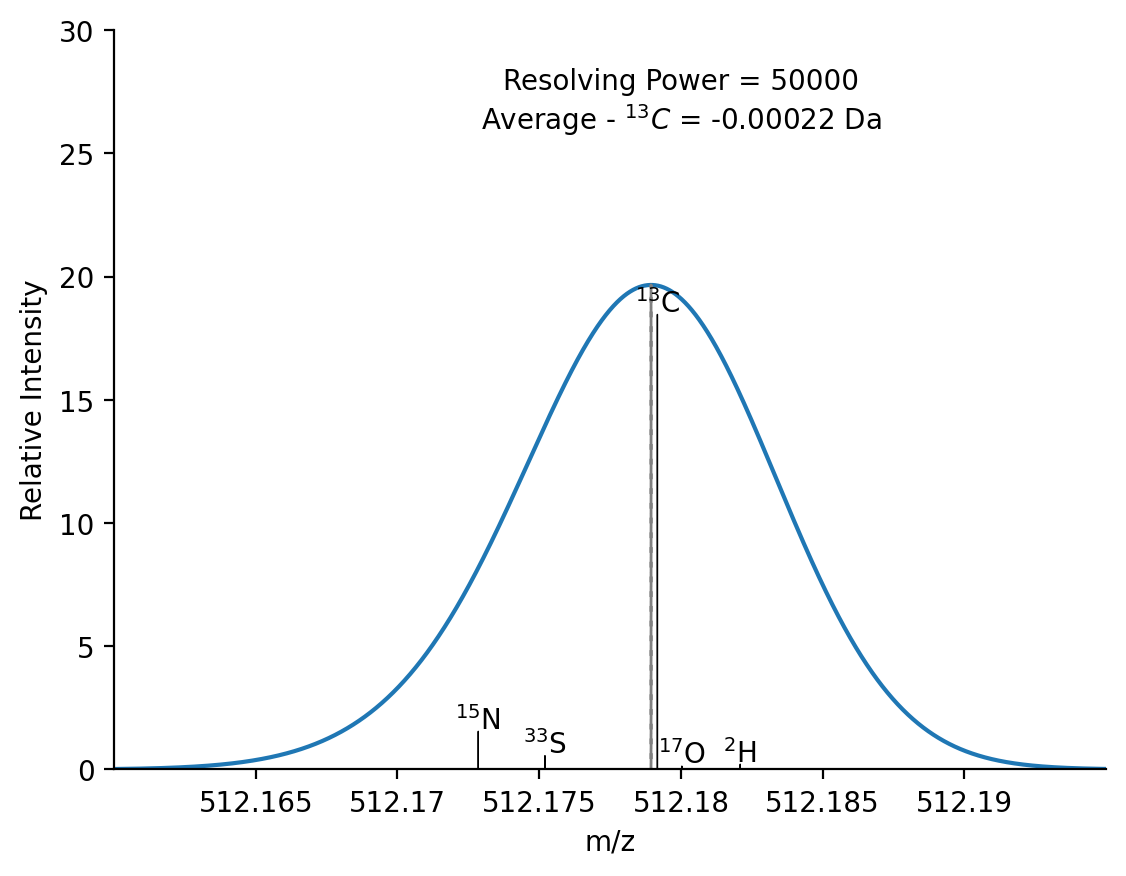

In [10]:
annotate_for_fwhm(0.01)

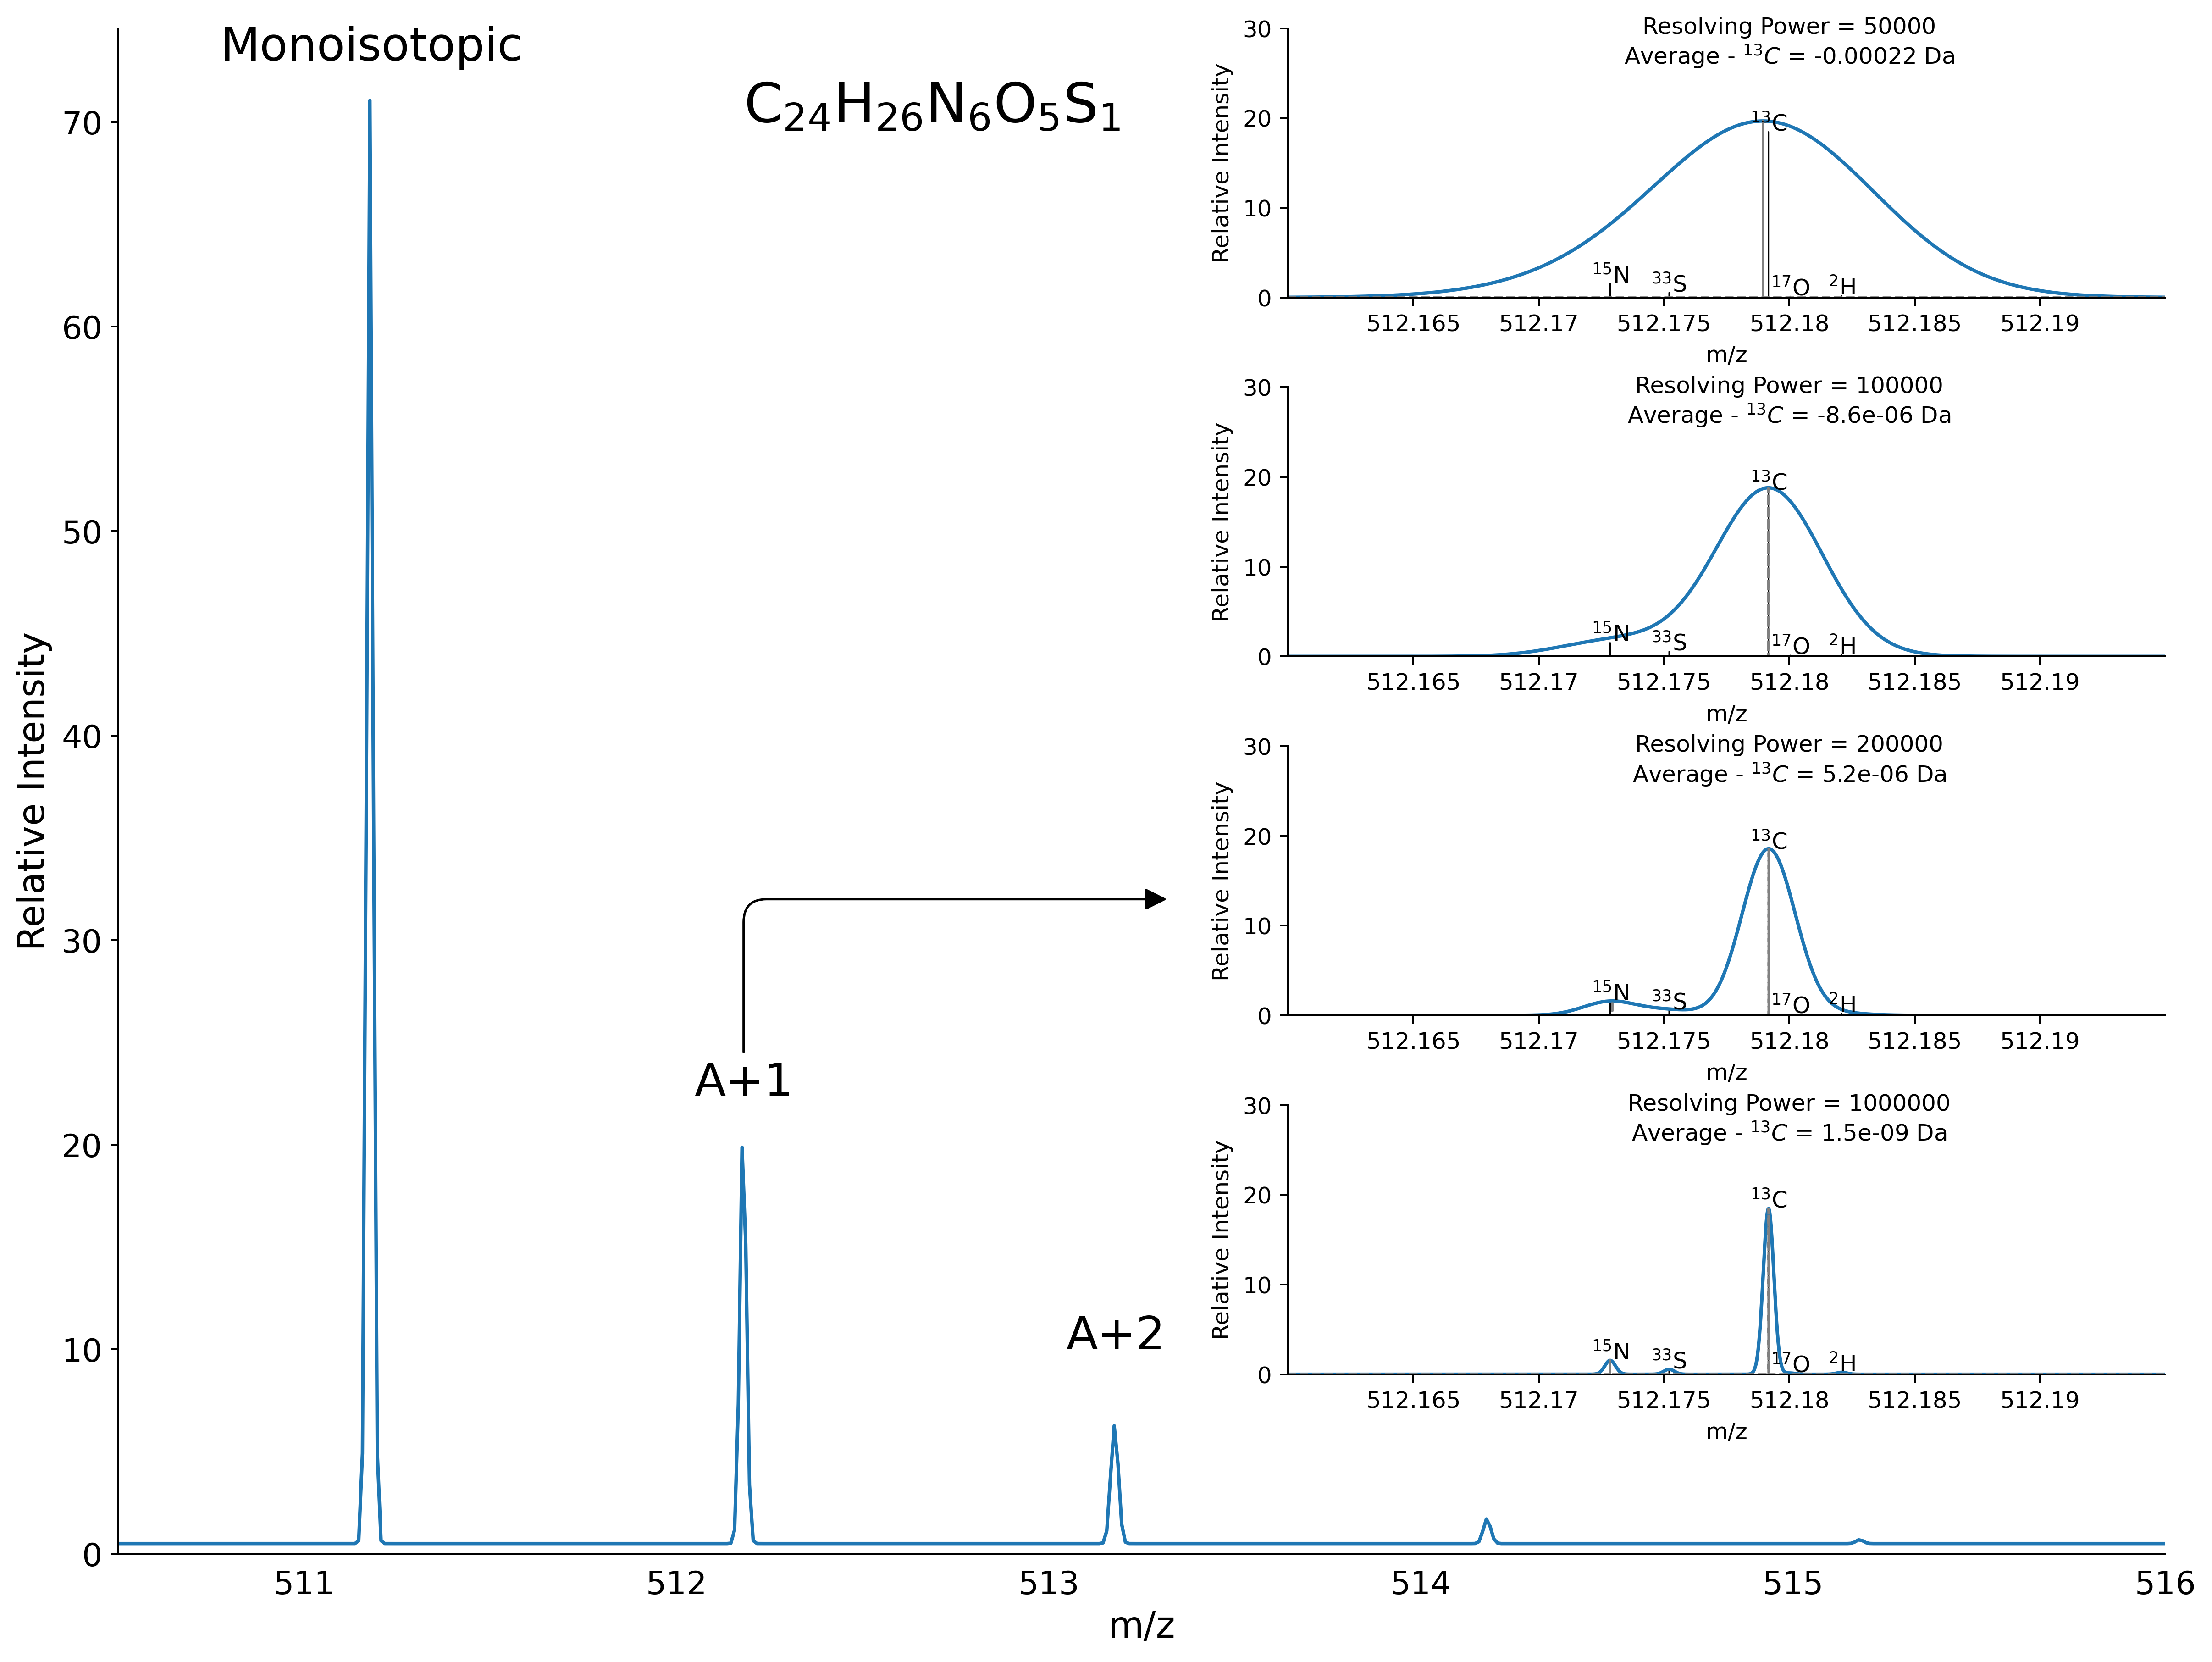

In [11]:
# Set up main canvas and segmented inset windows

gs = plt.GridSpec(9, 11, wspace=1, hspace=1)
fig = plt.figure(figsize=(16, 12), dpi=180)
root_ax = fig.add_subplot(gs[:, :])

# Draw the primary isotopic pattern
a, b = reprofile_fwhm(peaks, 0.02)

ms_peak_picker.plot.draw_raw(a, b + 0.5, ax=root_ax)
root_ax.set_xlim(510.5, 516)
root_ax.yaxis.get_major_formatter().set_scientific(False)

# Label the primary isotopic peaks
root_ax.text(511.18, 73, "Monoisotopic", ha="center", size=20)

root_ax.text(512.18, 70, ''.join([f"{k}$_{{{v}}}$" for k, v in comp.items()]), size=24)

root_ax.annotate(
    "A+1",
    (512.33 + 1, 25 + 7),
    (512.18, 23),
    arrowprops=dict(
        color="black",
        arrowstyle="-|>",
        connectionstyle="angle,angleA=90,angleB=0,rad=50",

    ),
    size=20,
    ha="center",
    va="center",
)

root_ax.text(513.18, 10, "A+2", ha="center", size=20)

# Generate insets of varying resolution
ax = fig.add_subplot(gs[:2, -5:])
annotate_for_fwhm(0.01, ax=ax)

ax = fig.add_subplot(gs[2:4, -5:])
annotate_for_fwhm(0.005, ax=ax)

ax = fig.add_subplot(gs[4:6, -5:])
annotate_for_fwhm(0.0025, ax=ax)

ax = fig.add_subplot(gs[6:8, -5:])
annotate_for_fwhm(0.0005, ax=ax)

root_ax.set_xlabel(root_ax.get_xlabel(), size=16)
root_ax.set_ylabel("Relative Intensity", size=16)

for f in root_ax.get_xticklabels():
    f.set_size(14)

for f in root_ax.get_yticklabels():
    f.set_size(14)

In [12]:
formula = "C23H38N6O7"
comp = brainpy.parse_formula(formula)

x = IsoSpecPy.IsoLayered(0.9999, formula)
x.sort_by_mass()

peaks = ms_peak_picker.PeakSet(
    [
        ms_peak_picker.FittedPeak(
            mass + brainpy.PROTON,
            prob * 100,
            prob,
            0,
            0,
            0.01,
            prob,
        )
        for mass, prob in zip(x.masses, x.probs)
    ]
)
peaks.reindex()

In [13]:
peaks[0].mz

511.28747405963

In [53]:
def annotate_for_fwhm3(fwhm, ax=None):
    # Draw the isotopic peaks
    ax = ms_peak_picker.plot.draw_peaklist(peaks, color="black", lw=0.5, pretty=False, ax=ax)

    # Use very, very high resolution to make sure we hit the peaks as pixel-
    # perfect as possible here because this is for pedantic humans.
    prof = reprofile_fwhm(peaks, fwhm, dx=0.00001)
    plt.plot(*prof)
    centroids = ms_peak_picker.pick_peaks(*prof)
    ms_peak_picker.plot.draw_peaklist(
        centroids,
        ax=ax,
        color="grey",
        lw=1,
        ls="--",
        pretty=False,
    )

    for elt, dif in neutron_delta.items():
        p = peaks.has_peak(peaks[0].mz + dif, 1e-6)
        if p:
            plt.text(p.mz, p.intensity + 0.1, elt, ha="center")
            (ep, _) = centroids.get_nearest_peak(peaks[0].mz + dif)
            print(int(500 / fwhm), elt, ep.mz - p.mz, f"{ep.mz:0.4f} - {p.mz:0.4f}")
        if elt == '$^{13}$C':
                delta_c = ep.mz - p.mz
    # Begin overly-specific formatting of the ticks and the axes
    ax.set_xlim(512.264, 512.314)
    ax.set_ylim(0, 30)
    ax.set_xticks(
        [512.264, 512.2724, 512.2828, 512.2932, 512.3036, 512.314],
        [512.264, 512.2724, 512.2828, 512.2932, 512.3036, 512.314],
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    y = ax.yaxis.get_major_formatter()
    y.set_useOffset(False)
    y.set_scientific(False)

    # This calculation is an approximation since the the m/z being measured isn't
    # 500 m/z, but close enough for our purposes. Resolving power = (m_0 / (m_1 - m_0))
    # where m_0 = 500 and m_1 = (500 + fwhm).
    ax.text(
        512.302,
        25,
        f"Resolving Power = {630 / fwhm:0.0f}\nAverage - $^{{13}}C$ = {delta_c:0.2g} Da",
        ha="center",
        size=12,
    )
    return ax


50000 $^{13}$C -0.00013562442984493828 512.2907 - 512.2908
50000 $^{2}$H -0.0030575351498782766 512.2907 - 512.2938
50000 $^{15}$N 0.006184315570067156 512.2907 - 512.2845
50000 $^{17}$O -0.0009979266299069423 512.2907 - 512.2917
100000 $^{13}$C 2.188057146668143e-05 512.2909 - 512.2908
100000 $^{2}$H -0.002900030148566657 512.2909 - 512.2938
100000 $^{15}$N 0.006341820571378776 512.2909 - 512.2845
100000 $^{17}$O -0.0008404216285953225 512.2909 - 512.2917
200000 $^{13}$C 7.769063245177676e-06 512.2908 - 512.2908
200000 $^{2}$H -0.0029141416567881606 512.2908 - 512.2938
200000 $^{15}$N 1.4547367754857987e-09 512.2845 - 512.2845
200000 $^{17}$O -0.0008545331368168263 512.2908 - 512.2917
1000000 $^{13}$C 2.252932063129265e-09 512.2908 - 512.2908
1000000 $^{2}$H -0.002921908467101275 512.2908 - 512.2938
1000000 $^{15}$N -1.020907802740112e-10 512.2845 - 512.2845
1000000 $^{17}$O -0.0008622999471299408 512.2908 - 512.2917


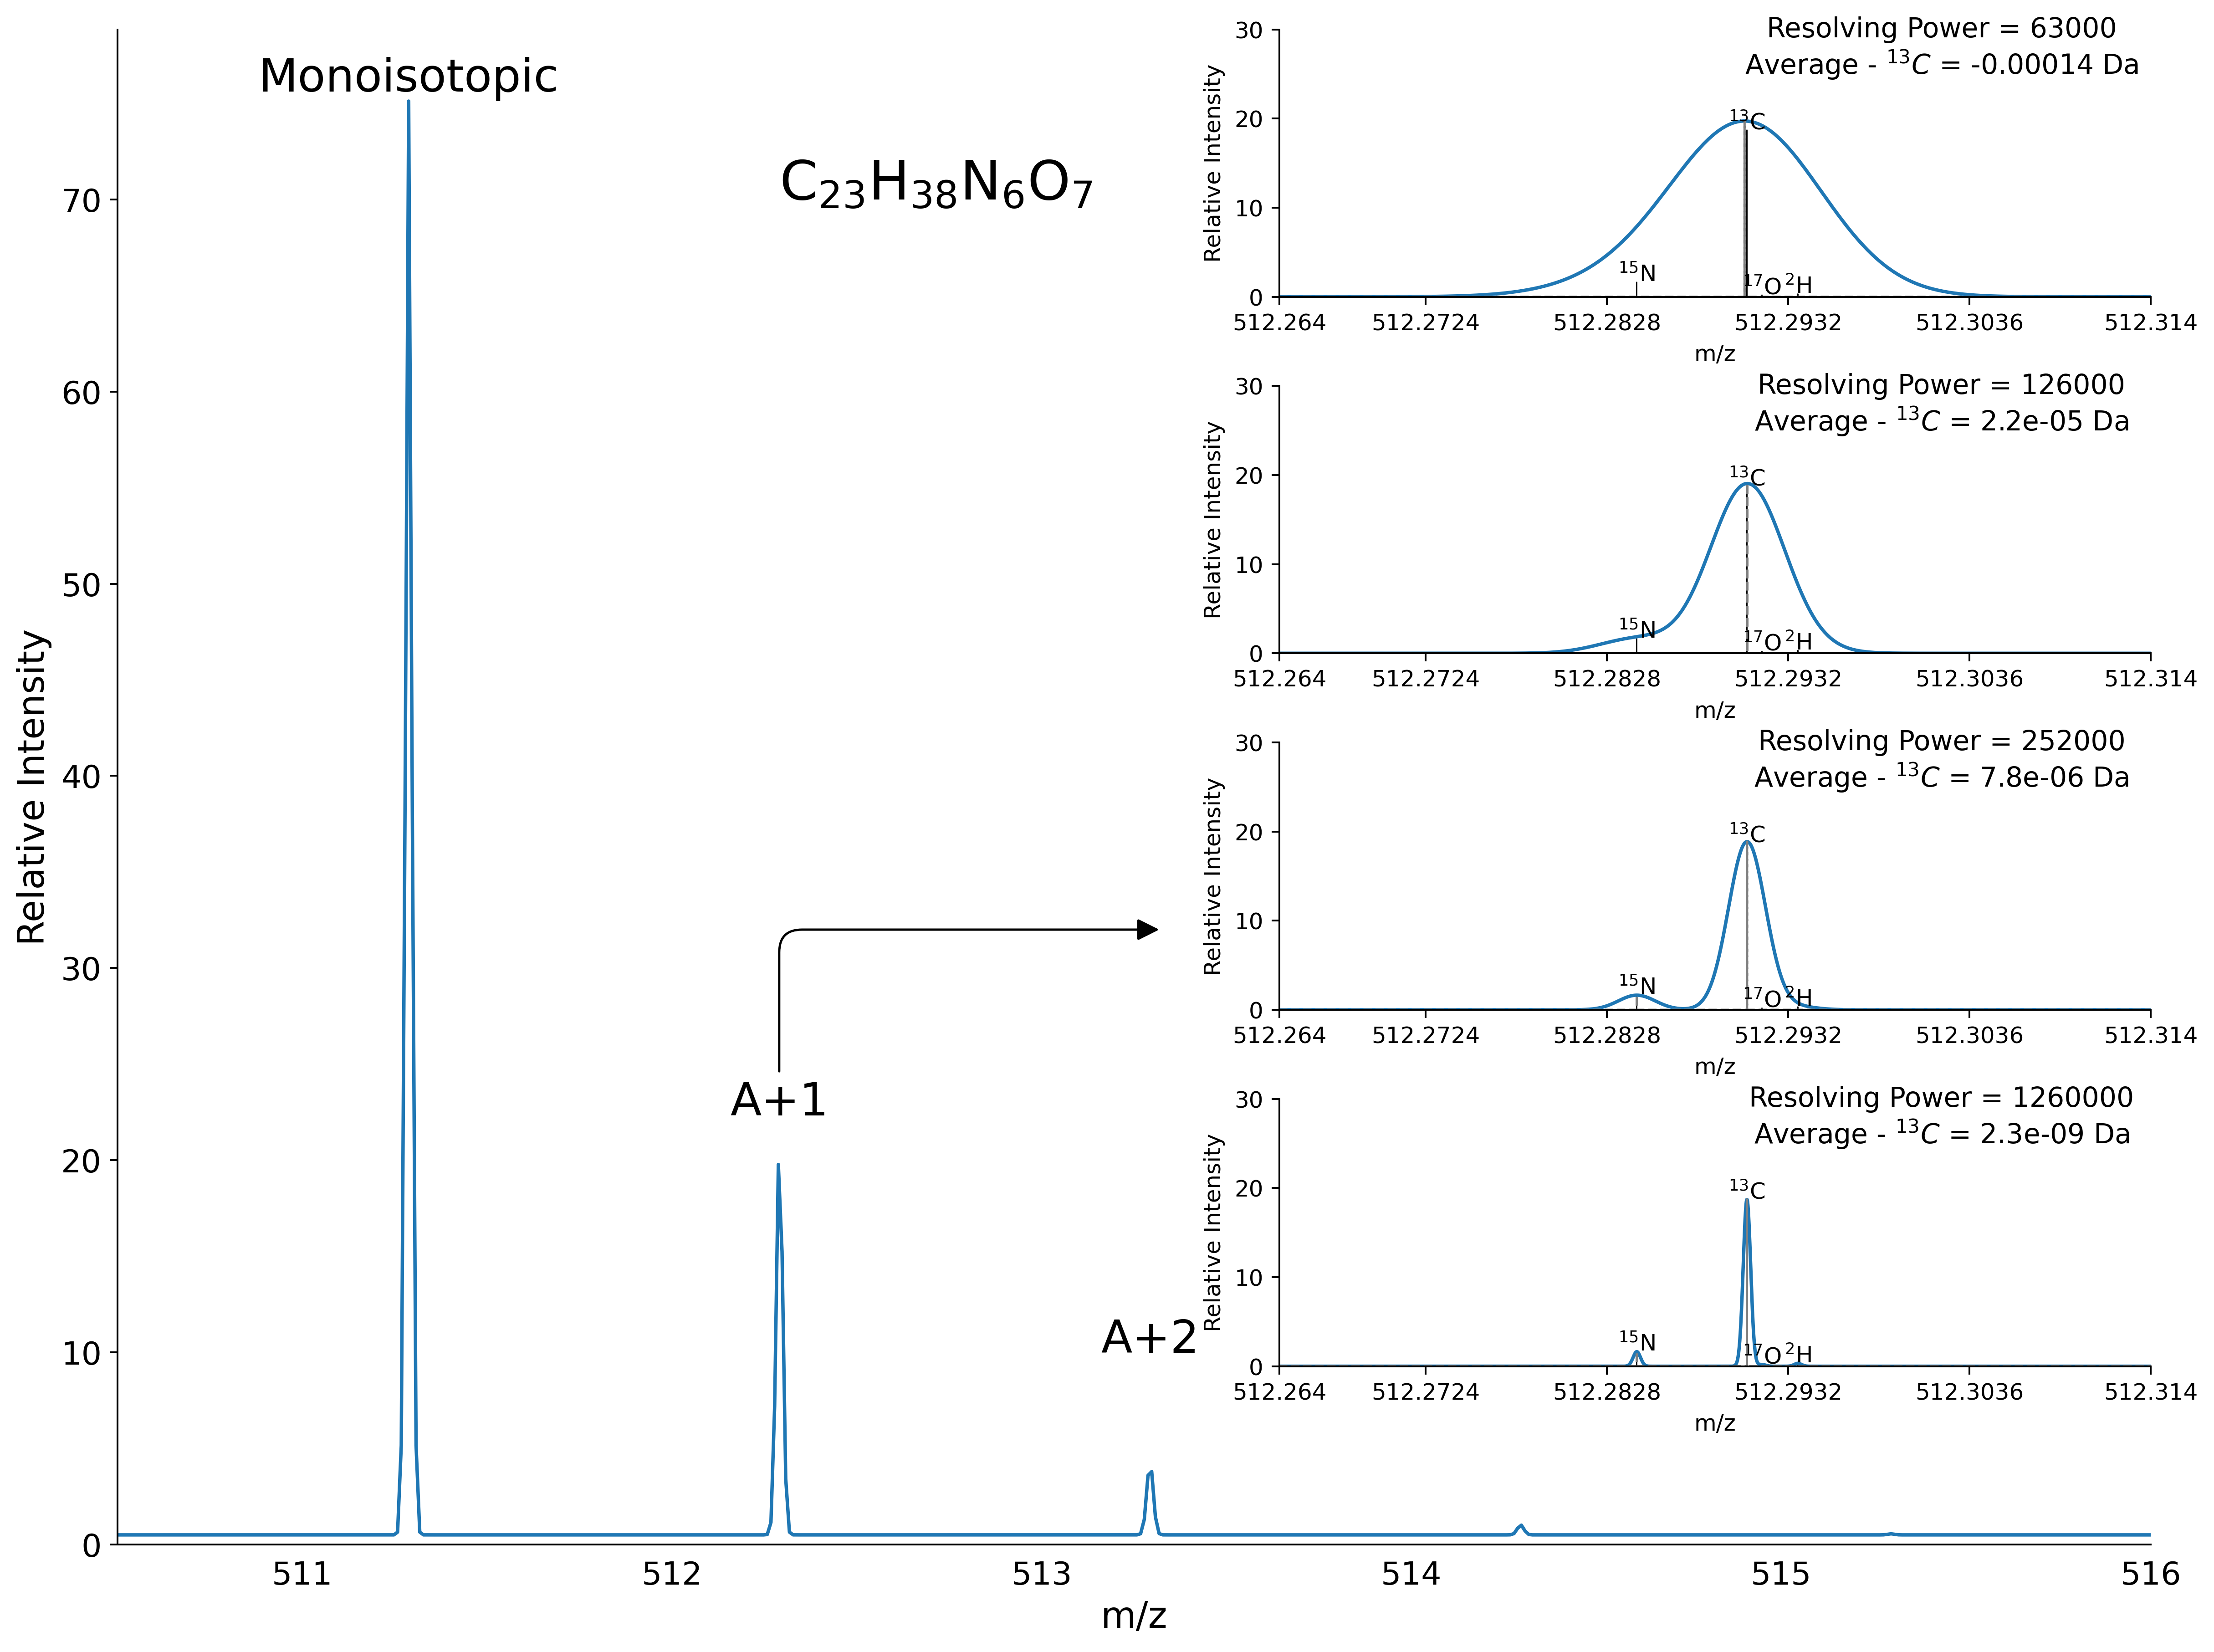

In [54]:
gs = plt.GridSpec(9, 11, wspace=1, hspace=1)
fig = plt.figure(figsize=(16, 12), dpi=180)
root_ax = fig.add_subplot(gs[:, :])

# Draw the primary isotopic pattern
a, b = reprofile_fwhm(peaks, 0.02)
agg_peaks = ms_peak_picker.pick_peaks(a, b)

ms_peak_picker.plot.draw_raw(a, b + 0.5, ax=root_ax)
root_ax.set_xlim(510.5, 516)
root_ax.yaxis.get_major_formatter().set_scientific(False)

# Label the primary isotopic peaks
root_ax.text(peaks[0].mz, peaks[0].intensity + 1, "Monoisotopic", ha="center", size=20)

root_ax.text(agg_peaks[1].mz, 70, "".join([f"{k}$_{{{v}}}$" for k, v in comp.items()]), size=24)

root_ax.annotate(
    "A+1",
    (512.33 + 1, 25 + 7),
    (agg_peaks[1].mz, 23),
    arrowprops=dict(
        color="black",
        arrowstyle="-|>",
        connectionstyle="angle,angleA=90,angleB=0,rad=50",
    ),
    size=20,
    ha="center",
    va="center",
)

root_ax.text(agg_peaks[2].mz, 10, "A+2", ha="center", size=20)

# Generate insets of varying resolution
ax = fig.add_subplot(gs[:2, -5:])
annotate_for_fwhm3(0.01, ax=ax)

ax = fig.add_subplot(gs[2:4, -5:])
annotate_for_fwhm3(0.005, ax=ax)

ax = fig.add_subplot(gs[4:6, -5:])
annotate_for_fwhm3(0.0025, ax=ax)

ax = fig.add_subplot(gs[6:8, -5:])
annotate_for_fwhm3(0.0005, ax=ax)

root_ax.set_xlabel(root_ax.get_xlabel(), size=16)
root_ax.set_ylabel("Relative Intensity", size=16)

for f in root_ax.get_xticklabels():
    f.set_size(14)

for f in root_ax.get_yticklabels():
    f.set_size(14)


In [23]:
formula = "C23H14Cl2N6O8S2"
comp = brainpy.parse_formula(formula)

x = IsoSpecPy.IsoLayered(0.9999, formula)
x.sort_by_mass()

peaks = ms_peak_picker.PeakSet(
    [
        ms_peak_picker.FittedPeak(
            mass + brainpy.PROTON,
            prob * 100,
            prob,
            0,
            0,
            0.01,
            prob,
        )
        for mass, prob in zip(x.masses, x.probs)
    ]
)
peaks.reindex()

In [30]:
neutron_delta = {
    f"$^{{{(brainpy.periodic_table[elt].isotopes[1].neutrons)}}}${elt}": brainpy.periodic_table[elt].isotopes[1].mass
    - brainpy.periodic_table[elt].isotopes[0].mass
    for elt in list(comp) if 1 in brainpy.periodic_table[elt].isotopes
}


In [32]:
neutron_delta

{'$^{13}$C': 1.0033548378,
 '$^{2}$H': 1.0062767457300001,
 '$^{15}$N': 0.9970348934000004,
 '$^{17}$O': 1.0042170804400001,
 '$^{33}$S': 0.9993877599999976}

In [80]:
def annotate_for_fwhm2(fwhm, ax=None):
    # Draw the isotopic peaks
    ax = ms_peak_picker.plot.draw_peaklist(peaks, color="black", lw=0.5, pretty=False, ax=ax)

    # Use very, very high resolution to make sure we hit the peaks as pixel-
    # perfect as possible here because this is for pedantic humans.
    prof = reprofile_fwhm(peaks, fwhm, dx=0.00001)
    plt.plot(*prof)
    centroids = ms_peak_picker.pick_peaks(*prof)
    ms_peak_picker.plot.draw_peaklist(
        centroids,
        ax=ax,
        color="grey",
        lw=1,
        ls="--",
        pretty=False,
    )

    for elt, dif in neutron_delta.items():
        p = peaks.has_peak(peaks[0].mz + dif, 1e-6)
        if p:
            plt.text(p.mz, p.intensity + 0.1, elt, ha="center")
            (ep, _) = centroids.get_nearest_peak(peaks[0].mz + dif)
            print(int(500 / fwhm), elt, ep.mz - p.mz, f"{ep.mz:0.4f} - {p.mz:0.4f}")

    # Begin overly-specific formatting of the ticks and the axes
    plt.xlim(637.95, 638.0)
    plt.ylim(0, 20)
    plt.xticks(
        [637.95, 637.96, 637.97, 637.98, 637.99, 638.0],
        [637.95, 637.96, 637.97, 637.98, 637.99, 638.0],
        # [512.165, 512.17, 512.175, 512.18, 512.185, 512.19],
        # [512.165, 512.17, 512.175, 512.18, 512.185, 512.19],
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    y = ax.yaxis.get_major_formatter()
    y.set_useOffset(False)
    y.set_scientific(False)

    # This calculation is an approximation since the the m/z being measured isn't
    # 500 m/z, but close enough for our purposes. Resolving power = (m_0 / (m_1 - m_0))
    # where m_0 = 500 and m_1 = (500 + fwhm).
    ax.text(637.99, 15, f"Resolving Power = {630 / fwhm:0.0f}", ha="center", size=12)
    return ax


In [81]:
import numpy as np
np.linspace(637.95, 638, 6)

array([637.95, 637.96, 637.97, 637.98, 637.99, 638.  ])

39682 $^{13}$C -0.0004287649555863027 637.9794 - 637.9798
39682 $^{2}$H -0.003350675675505954 637.9794 - 637.9827
39682 $^{15}$N 0.005891175044553165 637.9794 - 637.9735
39682 $^{17}$O -0.0012910671555346198 637.9794 - 637.9807
39682 $^{33}$S 0.003538334244467478 637.9794 - 637.9758


<AxesSubplot:xlabel='m/z', ylabel='Relative Intensity'>

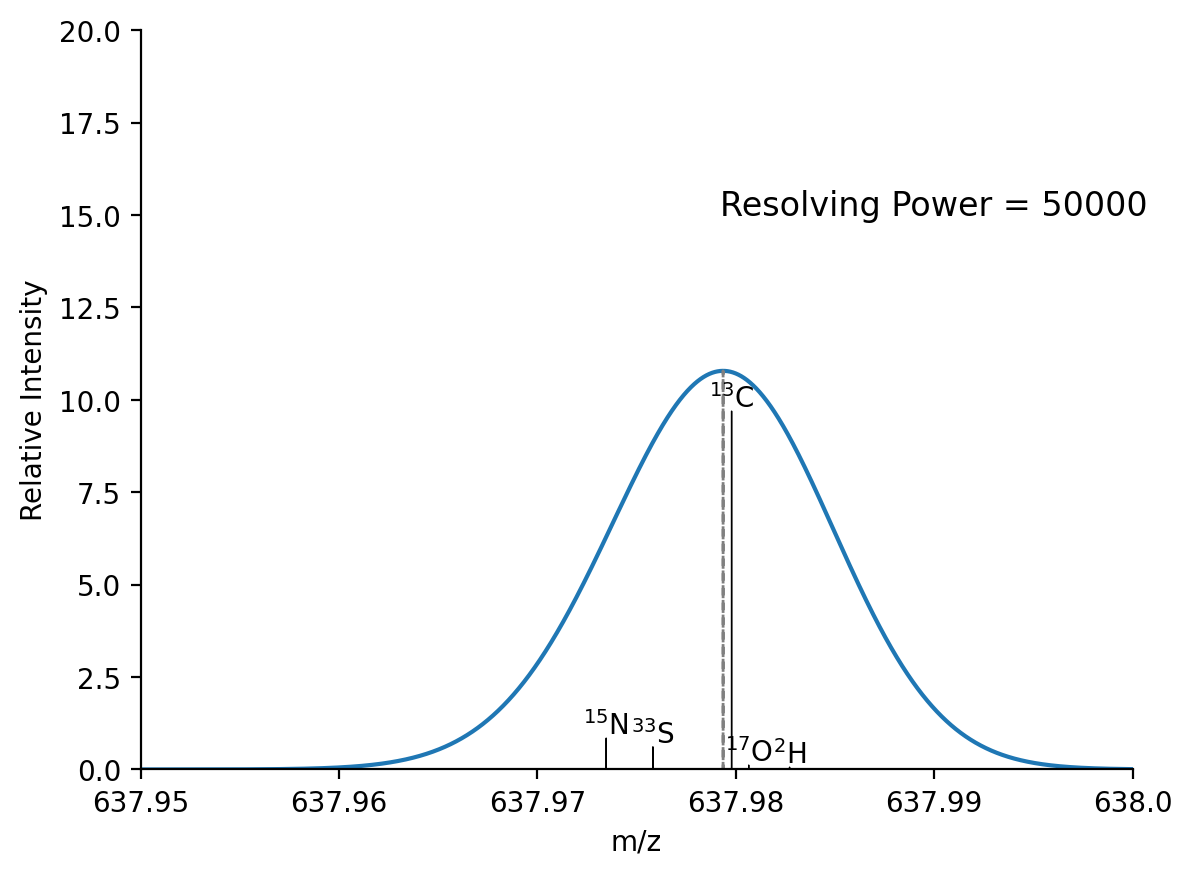

In [98]:
annotate_for_fwhm2(0.0126)

In [73]:
from pyteomics import proforma, parser, mass as libmass

In [182]:
peptide = proforma.ProForma.parse("GLEWVAVMSYNGNNK")
comp = dict(libmass.Composition(sequence = str(peptide[6:])))
comp['H'] -= 1
formula = "".join([f"{k}{v}" for k, v in comp.items()])
comp = brainpy.parse_formula(formula)

x = IsoSpecPy.IsoLayered(0.9999, formula)
x.sort_by_mass()

peaks = ms_peak_picker.PeakSet(
    [
        ms_peak_picker.FittedPeak(
            mass + brainpy.PROTON,
            prob * 100,
            prob,
            0,
            0,
            0.01,
            prob,
        )
        for mass, prob in zip(x.masses, x.probs)
    ]
)
peaks.reindex()

In [183]:
def annotate_for_fwhm_conf(fwhm, peaks, agg_peaks, ax=None):
    # Draw the isotopic peaks
    ax = ms_peak_picker.plot.draw_peaklist(peaks, color="black", lw=0.5, pretty=False, ax=ax)

    # Use very, very high resolution to make sure we hit the peaks as pixel-
    # perfect as possible here because this is for pedantic humans.
    prof = reprofile_fwhm(peaks, fwhm, dx=0.00001)
    plt.plot(*prof)
    centroids = ms_peak_picker.pick_peaks(*prof)
    ms_peak_picker.plot.draw_peaklist(
        centroids,
        ax=ax,
        color="grey",
        lw=1,
        ls="--",
        pretty=False,
    )

    delta_c = None
    delta_c_ppm = None
    for elt, dif in neutron_delta.items():
        p = peaks.has_peak(peaks[0].mz + dif, 1e-6)
        if p:
            plt.text(p.mz, p.intensity + 0.1, elt, ha="center")
            (ep, _) = centroids.get_nearest_peak(peaks[0].mz + dif)
            print(int(500 / fwhm), elt, ep.mz - p.mz, f"{ep.mz:0.4f} - {p.mz:0.4f}")
            if elt == "$^{13}$C":
                delta_c = ep.mz - p.mz
                delta_c_ppm = (ep.mz - p.mz) / p.mz * 1e6

    # Begin overly-specific formatting of the ticks and the axes
    plt.xlim(agg_peaks[1].mz - 0.02, agg_peaks[1].mz + 0.02)

    plt.ticklabel_format(useOffset=False, axis="x")
    plt.xticks(
        np.linspace(agg_peaks[1].mz - 0.019, agg_peaks[1].mz + 0.019, 6),
        ['%0.3f' % i for i in np.linspace(agg_peaks[1].mz - 0.019, agg_peaks[1].mz + 0.019, 6)],
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    y = ax.yaxis.get_major_formatter()
    y.set_useOffset(False)
    y.set_scientific(False)

    # This calculation is an approximation since the the m/z being measured isn't
    # 500 m/z, but close enough for our purposes. Resolving power = (m_0 / (m_1 - m_0))
    # where m_0 = 500 and m_1 = (500 + fwhm).
    ax.text(
        agg_peaks[1].mz,
        40,
        f"Resolving Power = {agg_peaks[1].mz / fwhm:0.0f}\nAverage - $^{{13}}C$ = {delta_c:0.2g} Da, {delta_c_ppm:0.2g} PPM",
        ha="center",
        size=12,
    )
    return ax


25000 $^{13}$C -0.00046656338622597104 1026.4624 - 1026.4628
25000 $^{2}$H -0.0033884741062593093 1026.4624 - 1026.4658
25000 $^{15}$N 0.005853376613686123 1026.4624 - 1026.4565
25000 $^{17}$O -0.0013288655861742882 1026.4624 - 1026.4637
25000 $^{33}$S 0.0035005358138278098 1026.4624 - 1026.4589
50000 $^{13}$C -0.00021669596503670618 1026.4626 - 1026.4628
50000 $^{2}$H -0.0031386066850700445 1026.4626 - 1026.4658
50000 $^{15}$N 0.006103244034875388 1026.4626 - 1026.4565
50000 $^{17}$O -0.0010789981649850233 1026.4626 - 1026.4637
50000 $^{33}$S 0.0037504032350170746 1026.4626 - 1026.4589
100000 $^{13}$C 9.171654710371513e-06 1026.4628 - 1026.4628
100000 $^{2}$H -0.0029127390653229668 1026.4628 - 1026.4658
100000 $^{15}$N 0.006329111654622466 1026.4628 - 1026.4565
100000 $^{17}$O -0.0008531305452379456 1026.4628 - 1026.4637
100000 $^{33}$S 0.003976270854764152 1026.4628 - 1026.4589
500000 $^{13}$C 1.379818286295631e-06 1026.4628 - 1026.4628
500000 $^{2}$H -0.0029205309017470427 1026.4628

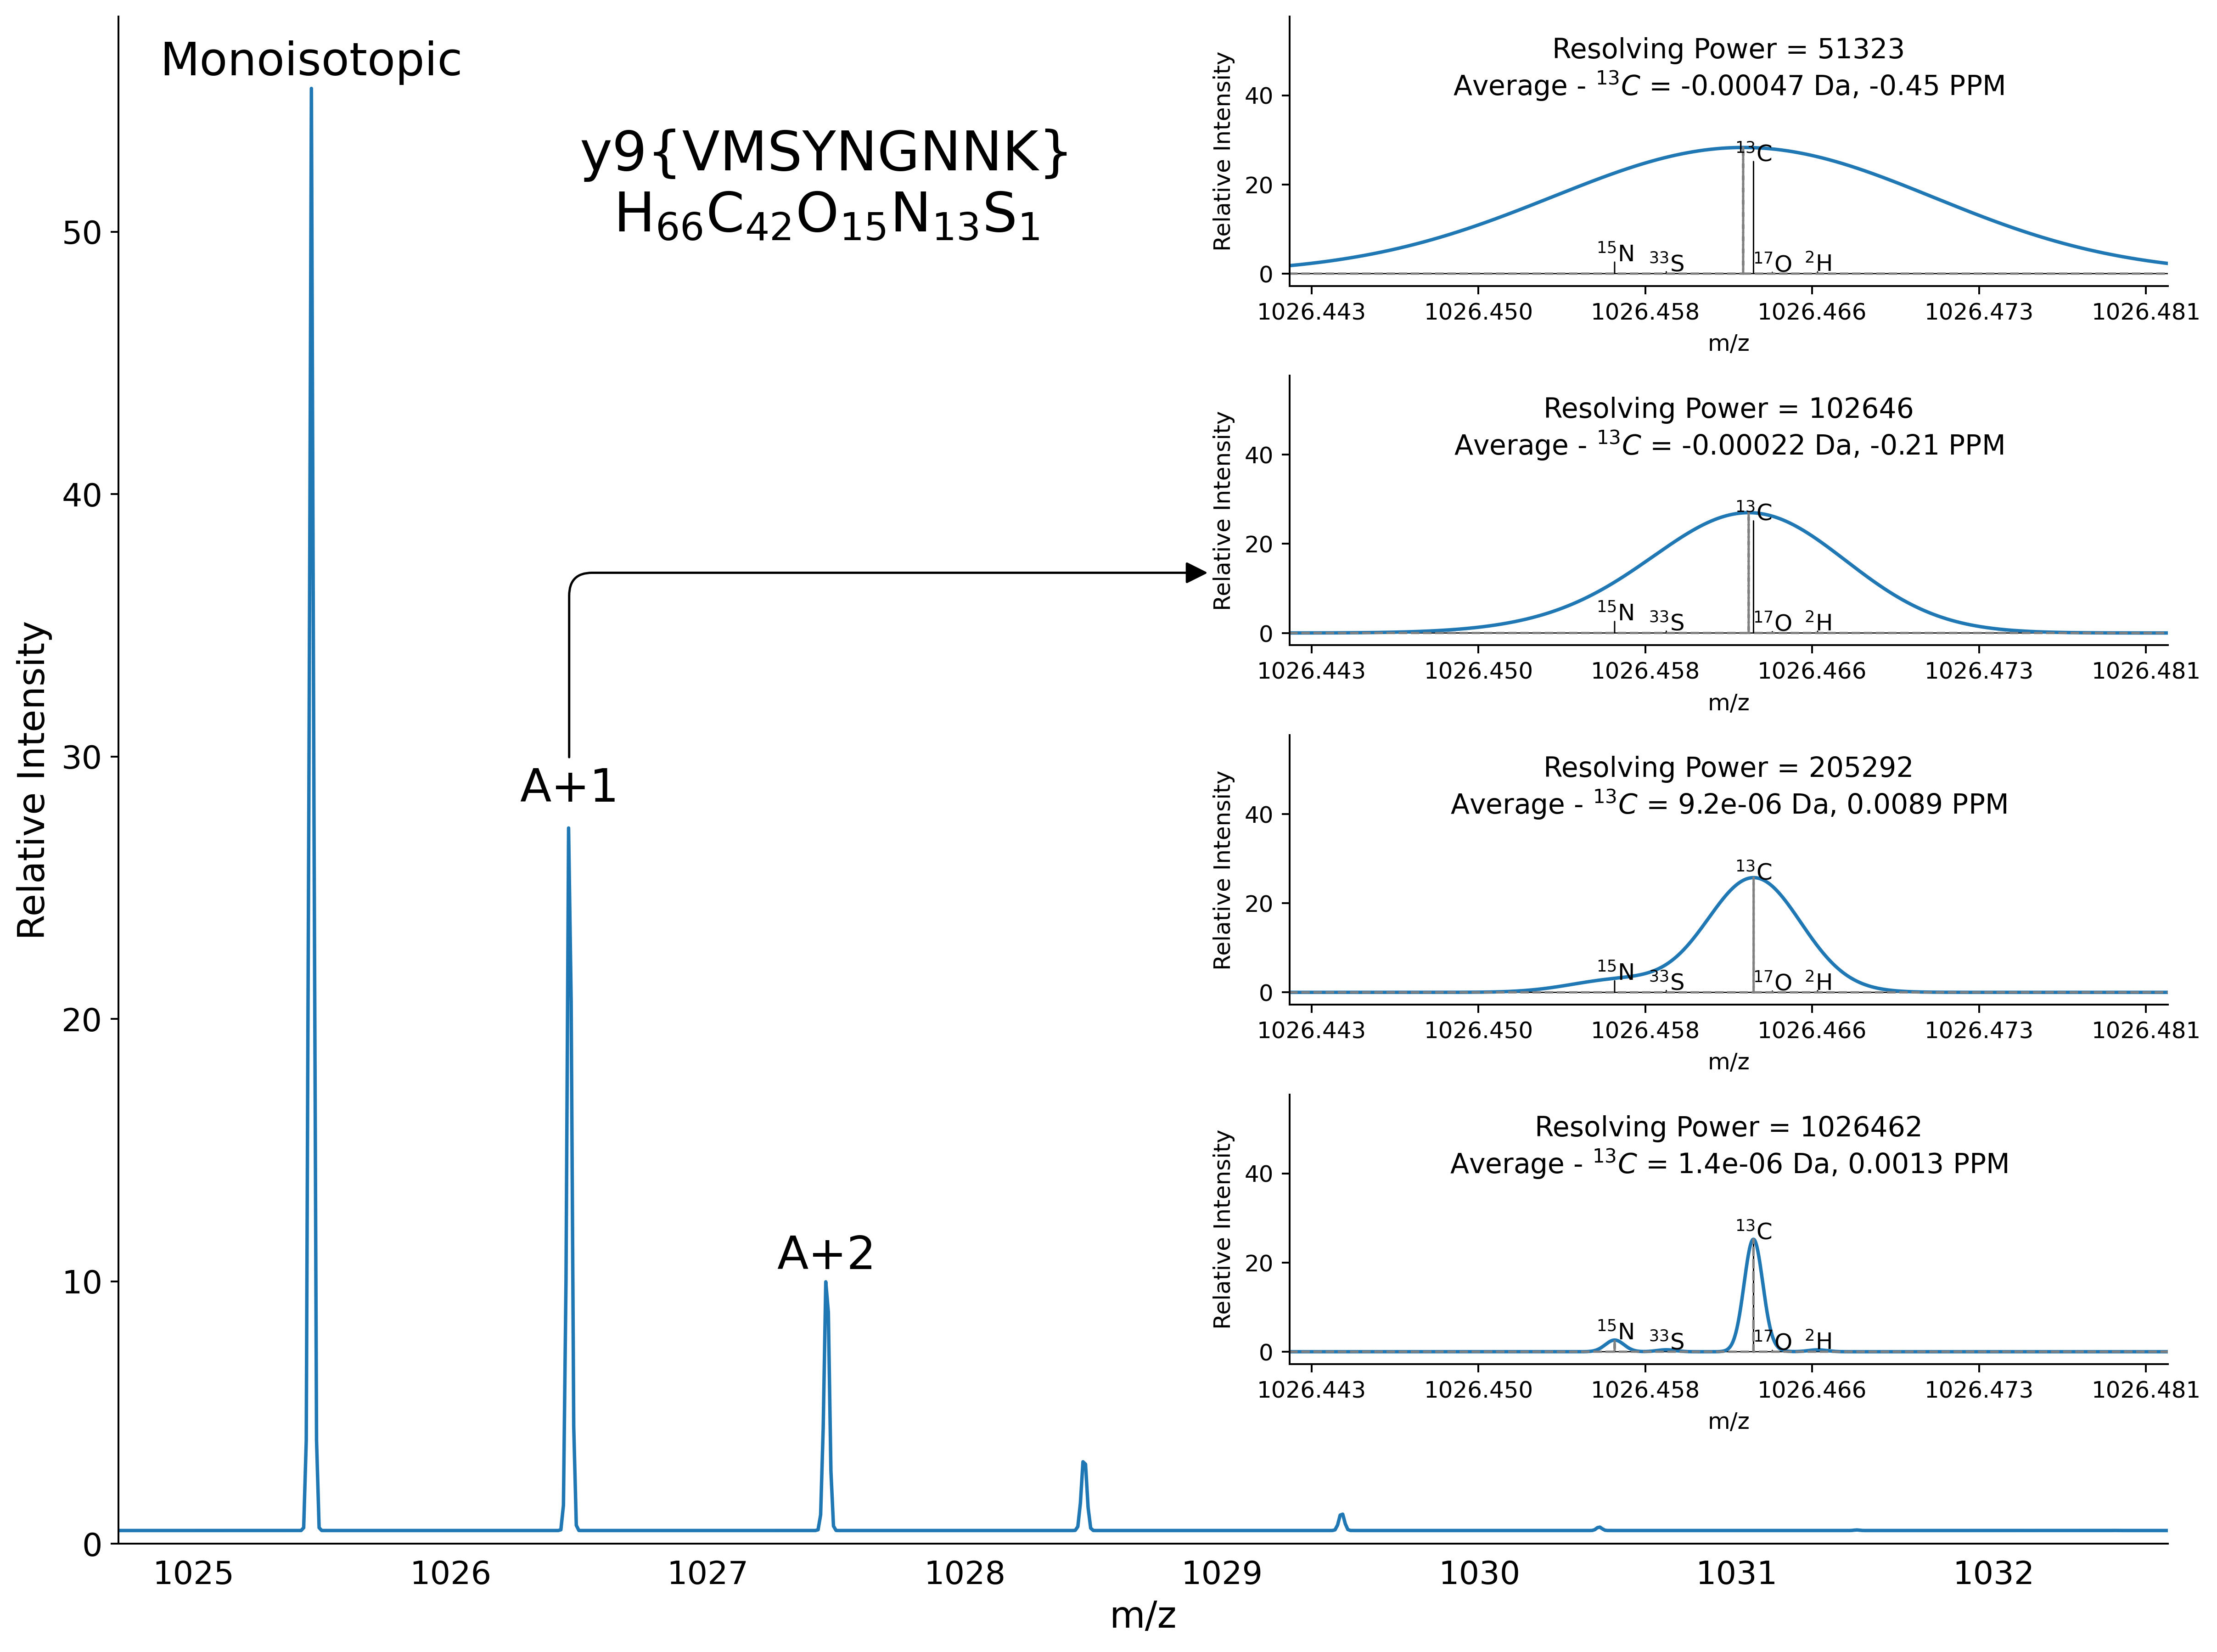

In [185]:
gs = plt.GridSpec(9, 11, wspace=1, hspace=1)
fig = plt.figure(figsize=(16, 12), dpi=180)
root_ax = fig.add_subplot(gs[:, :])

# Draw the primary isotopic pattern
a, b = reprofile_fwhm(peaks, 0.02)
agg_peaks = ms_peak_picker.pick_peaks(a, b)

ms_peak_picker.plot.draw_raw(a, b + 0.5, ax=root_ax)
root_ax.set_xlim(peaks[0].mz - 0.75, peaks[-1].mz + 0.2)
root_ax.yaxis.get_major_formatter().set_scientific(False)

# Label the primary isotopic peaks
root_ax.text(peaks[0].mz, peaks[0].intensity + 1, "Monoisotopic", ha="center", size=20)

root_ax.text(agg_peaks[2].mz, 50, f"y9{{{peptide[6:]}}}\n" + "".join([f"{k}$_{{{v}}}$" for k, v in comp.items()]), size=24, ha='center')

root_ax.annotate(
    "A+1",
    (agg_peaks[-2].mz + 1.5, 30 + 7),
    (agg_peaks[1].mz, agg_peaks[1].intensity + 2),
    arrowprops=dict(
        color="black",
        arrowstyle="-|>",
        connectionstyle="angle,angleA=90,angleB=0,rad=50",
    ),
    size=20,
    ha="center",
    va="center",
)

root_ax.text(agg_peaks[2].mz, agg_peaks[2].intensity + 1, "A+2", ha="center", size=20)

# # Generate insets of varying resolution
ax = fig.add_subplot(gs[:2, -5:])
annotate_for_fwhm_conf(0.02, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

ax = fig.add_subplot(gs[2:4, -5:])
annotate_for_fwhm_conf(0.01, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

ax = fig.add_subplot(gs[4:6, -5:])
annotate_for_fwhm_conf(0.005, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

ax = fig.add_subplot(gs[6:8, -5:])
annotate_for_fwhm_conf(0.001, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

root_ax.set_xlabel(root_ax.get_xlabel(), size=16)
root_ax.set_ylabel("Relative Intensity", size=16)

for f in root_ax.get_xticklabels():
    f.set_size(14)

for f in root_ax.get_yticklabels():
    f.set_size(14)


In [177]:
peptide = "CMNR"
comp = dict(libmass.Composition(sequence=peptide))
comp["H"] -= 1
formula = "".join([f"{k}{v}" for k, v in comp.items()])
comp = brainpy.parse_formula(formula)

x = IsoSpecPy.IsoLayered(0.9999, formula)
x.sort_by_mass()

peaks = ms_peak_picker.PeakSet(
    [
        ms_peak_picker.FittedPeak(
            mass + brainpy.PROTON,
            prob * 100,
            prob,
            0,
            0,
            0.01,
            prob,
        )
        for mass, prob in zip(x.masses, x.probs)
    ]
)
peaks.reindex()

50000 $^{13}$C -0.0004787838953461687 523.2066 - 523.2071
50000 $^{2}$H -0.003400694615379507 523.2066 - 523.2100
50000 $^{15}$N 0.005841156104679612 523.2066 - 523.2008
50000 $^{17}$O -0.0013410860954081727 523.2066 - 523.2079
50000 $^{33}$S 0.0034883153045939252 523.2066 - 523.2031
100000 $^{13}$C -3.754314866455388e-05 523.2070 - 523.2071
100000 $^{2}$H -0.002959453868697892 523.2070 - 523.2100
100000 $^{15}$N 0.006282396851361227 523.2070 - 523.2008
100000 $^{17}$O -0.0008998453487265579 523.2070 - 523.2079
100000 $^{33}$S 0.00392955605127554 523.2070 - 523.2031
200000 $^{13}$C 8.236629241764604e-06 523.2071 - 523.2071
200000 $^{2}$H -0.0029136740907915737 523.2071 - 523.2100
200000 $^{15}$N 0.00013702545447813463 523.2009 - 523.2008
200000 $^{17}$O -0.0008540655708202394 523.2071 - 523.2079
200000 $^{33}$S -0.0022158153456075524 523.2009 - 523.2031
1000000 $^{13}$C 2.4831479095155373e-09 523.2071 - 523.2071
1000000 $^{2}$H -0.0029219082368854288 523.2071 - 523.2100
1000000 $^{15}$

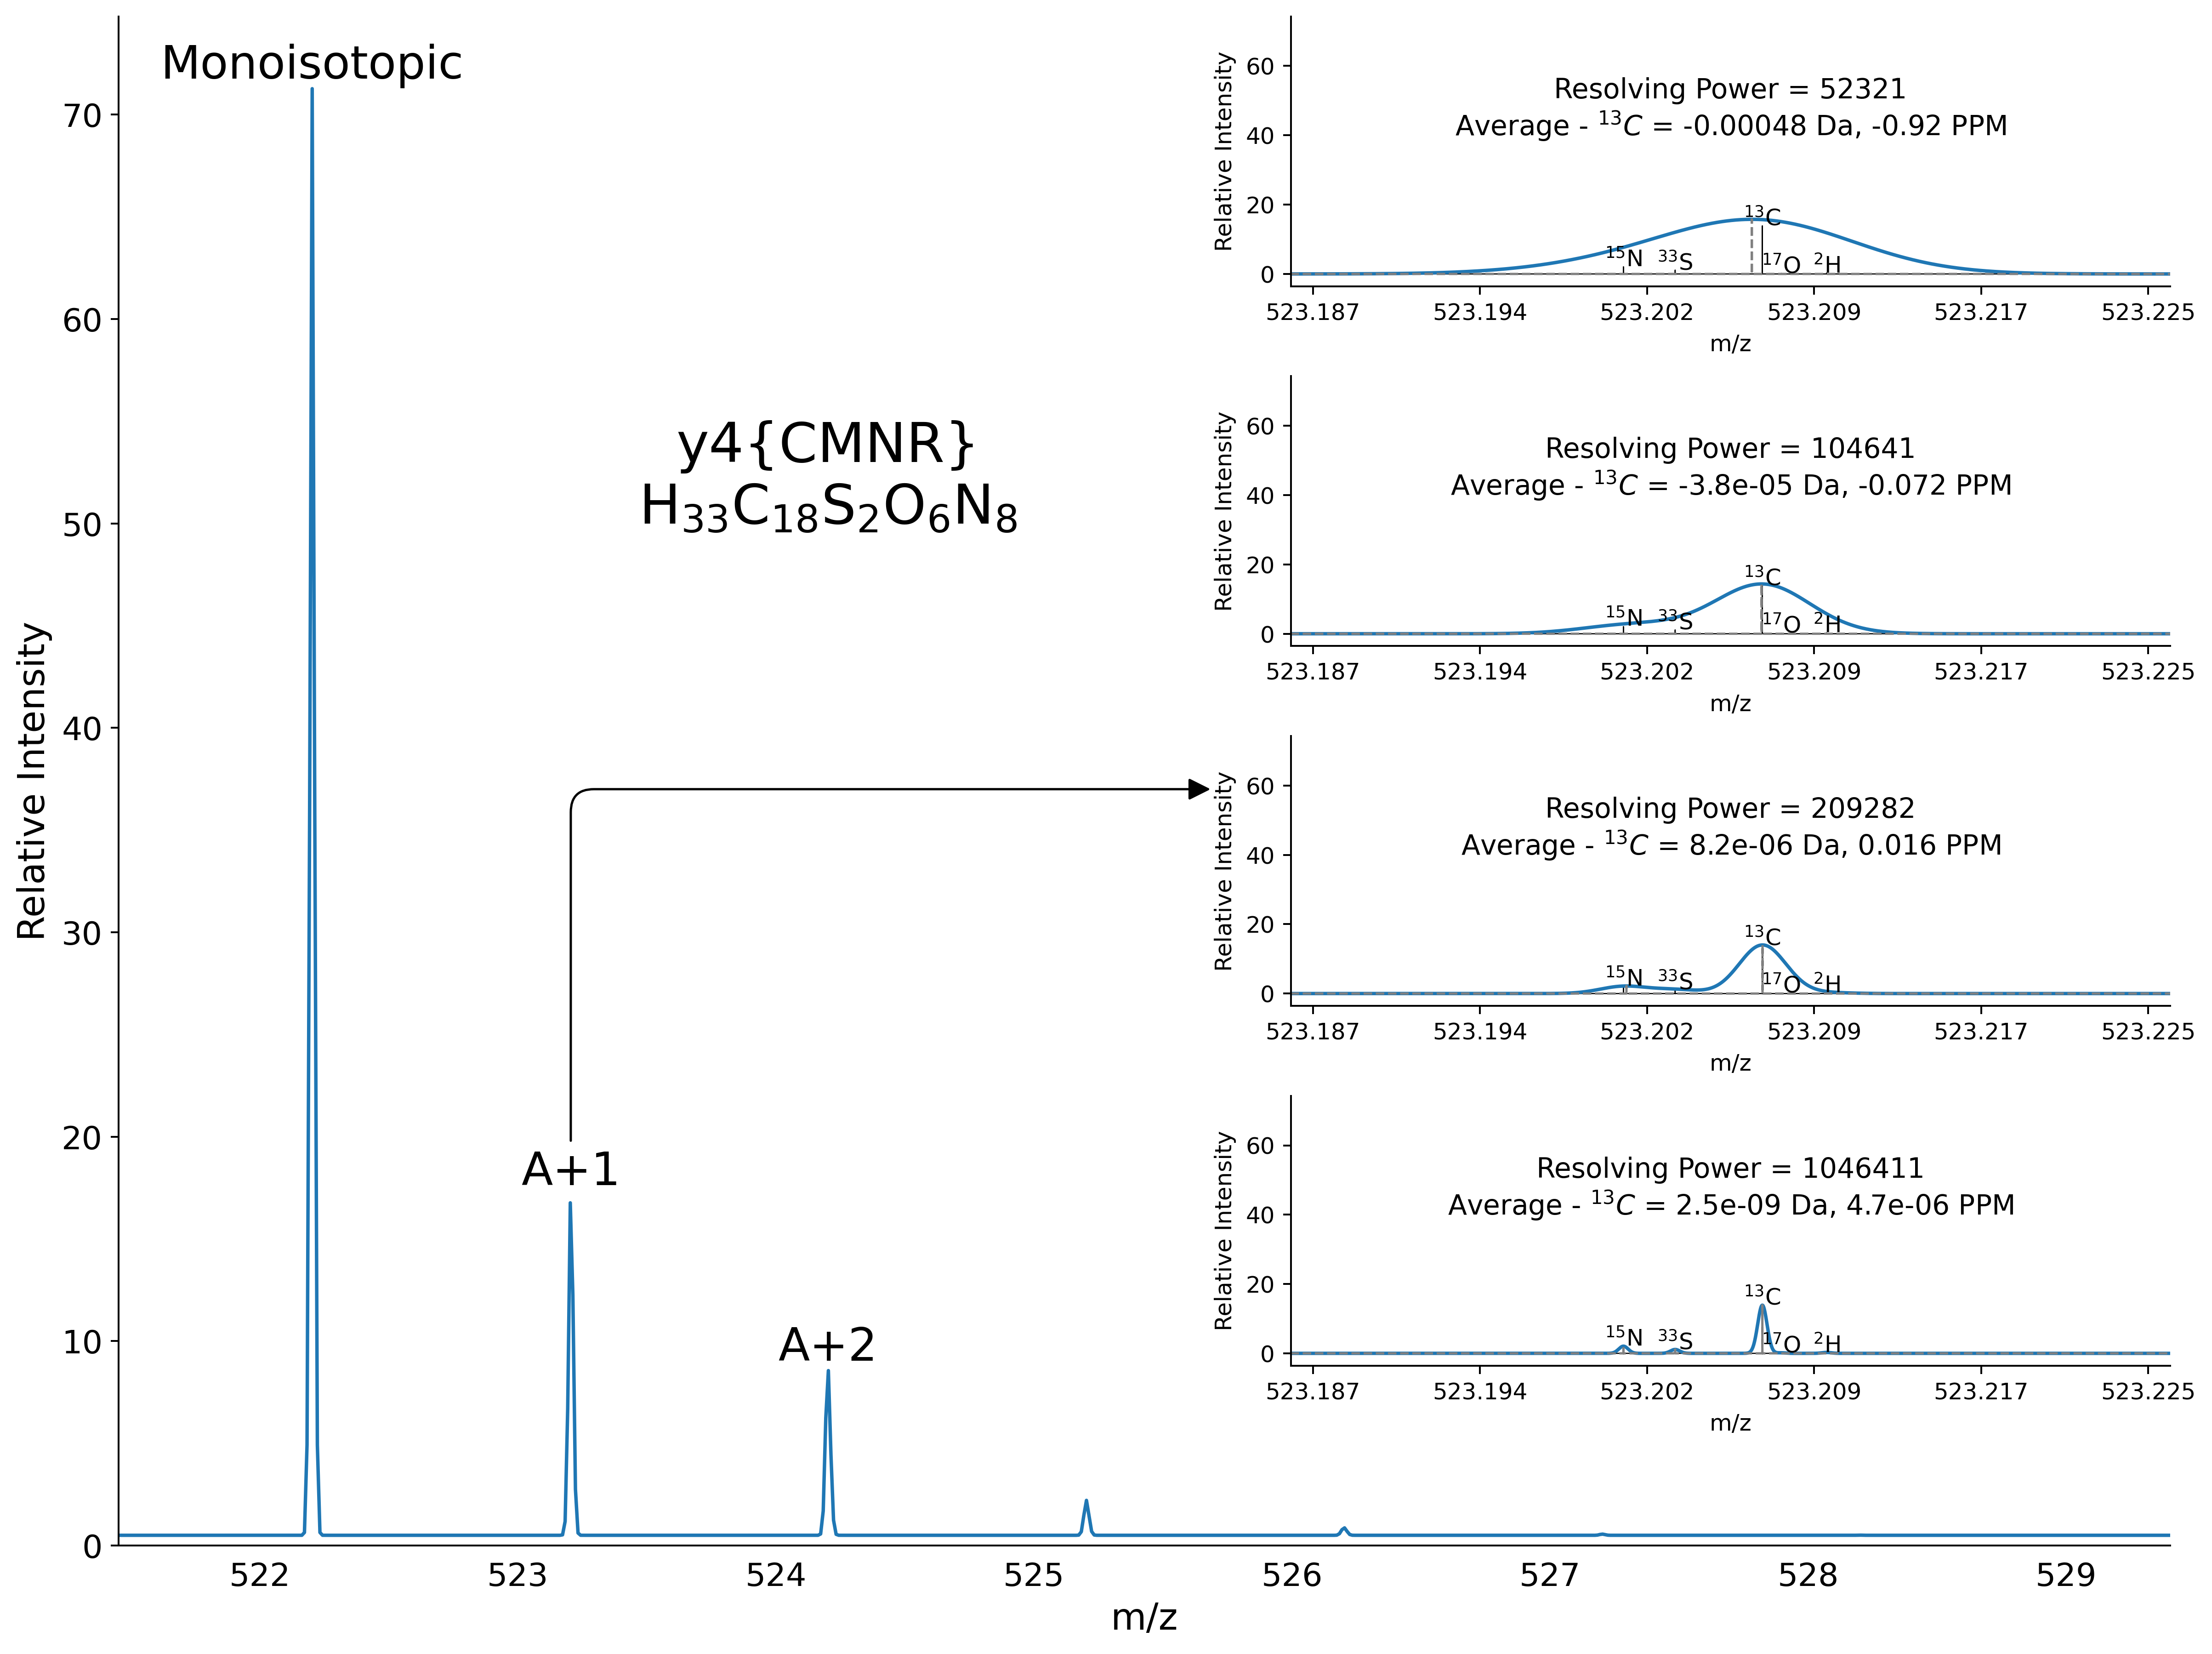

In [178]:
gs = plt.GridSpec(9, 11, wspace=1, hspace=1)
fig = plt.figure(figsize=(16, 12), dpi=180)
root_ax = fig.add_subplot(gs[:, :])

# Draw the primary isotopic pattern
a, b = reprofile_fwhm(peaks, 0.02)
agg_peaks = ms_peak_picker.pick_peaks(a, b)

ms_peak_picker.plot.draw_raw(a, b + 0.5, ax=root_ax)
root_ax.set_xlim(peaks[0].mz - 0.75, peaks[-1].mz + 0.2)
root_ax.yaxis.get_major_formatter().set_scientific(False)

# Label the primary isotopic peaks
root_ax.text(peaks[0].mz, peaks[0].intensity + 1, "Monoisotopic", ha="center", size=20)

root_ax.text(
    agg_peaks[2].mz,
    50,
    f"y4{{{peptide}}}\n" + "".join([f"{k}$_{{{v}}}$" for k, v in comp.items()]),
    size=24,
    ha="center",
)

root_ax.annotate(
    "A+1",
    (agg_peaks[-2].mz + 1.5, 30 + 7),
    (agg_peaks[1].mz, agg_peaks[1].intensity + 2),
    arrowprops=dict(
        color="black",
        arrowstyle="-|>",
        connectionstyle="angle,angleA=90,angleB=0,rad=50",
    ),
    size=20,
    ha="center",
    va="center",
)

root_ax.text(agg_peaks[2].mz, agg_peaks[2].intensity + 1, "A+2", ha="center", size=20)

# # Generate insets of varying resolution
ax = fig.add_subplot(gs[:2, -5:])
annotate_for_fwhm_conf(0.01, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

ax = fig.add_subplot(gs[2:4, -5:])
annotate_for_fwhm_conf(0.005, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

ax = fig.add_subplot(gs[4:6, -5:])
annotate_for_fwhm_conf(0.0025, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

ax = fig.add_subplot(gs[6:8, -5:])
annotate_for_fwhm_conf(0.0005, peaks=peaks, agg_peaks=agg_peaks, ax=ax)

root_ax.set_xlabel(root_ax.get_xlabel(), size=16)
root_ax.set_ylabel("Relative Intensity", size=16)

for f in root_ax.get_xticklabels():
    f.set_size(14)

for f in root_ax.get_yticklabels():
    f.set_size(14)
